# Pancake Flipping - Statistical Analysis and Inference

In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_ind

In [2]:
#Read the data as a data frame
df_org = pd.read_csv('data.csv')

In [3]:
df_org.head()

,match_day,name,hand,score,attempts
0,1,Arielle,R,8,20
1,2,Arielle,R,10,20
2,3,Arielle,R,6,20
3,4,Arielle,L,4,20
4,5,Arielle,R,7,20


In [4]:
df_org.tail()

,match_day,name,hand,score,attempts
95,46,Boris,R,10,20
96,47,Boris,L,4,20
97,48,Boris,R,12,20
98,49,Boris,L,4,20
99,50,Boris,L,7,20


In [5]:
df_org.shape

(100, 5)

In [6]:
df_org.nunique()

match_day    50
name          2
hand          2
score        13
attempts      1
dtype: int64

In [7]:
df_org.attempts.unique()

array([20], dtype=int64)

Observation:
1. Column 'attempts' seems to be having the same value(20 attempts) across all records. Hence removing this column. This column would have contributed significantly to arrive at the success(score/attempts) with 'coefficent of variation' if it had been having variants in it.

In [8]:
df_org.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   match_day  100 non-null    int64 
 1   name       100 non-null    object
 2   hand       100 non-null    object
 3   score      100 non-null    int64 
 4   attempts   100 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 4.0+ KB


### Performing EDA

Understanding data type of each variable given in the dataset:

column 'match_day' - numerical(discrete) - unique id 
column 'name' - categorical(nominal)
column 'hand' - categorical(nominal)
column 'score' - numerical(discrete)
column 'attempts' - numerical(discrete)

In [9]:
# Checking the presence of missing values
df_org.isnull().values.any() # dataframe contains only 'false' which means there are no null values.
total_nan = df_org.isnull().sum().sum()
if total_nan==0:
    print("====> There are no NaN values present in the original dataset")
else:
    print("====> There are NaN values present in the original dataset. Null count is", total_nan)

====> There are no NaN values present in the original dataset


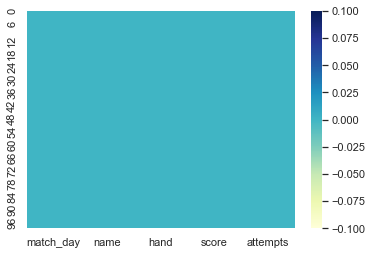

In [10]:
sns.heatmap(df_org.isnull(), cmap="YlGnBu");

In [11]:
# Duplicate check
print("Duplicate rows present in the dataset: ", df_org[df_org.duplicated()].shape[0])

Duplicate rows present in the dataset:  0


Observation:
1. There are no null values in the given dataset
2. There are no duplicate records in the given dataset

In [12]:
# EDA - 5 point summary of numerical attributes
df_summary = df_org.describe().transpose()
df_summary

,count,mean,std,min,25%,50%,75%,max
match_day,100.0,25.50,14.503570,1.0,13.0,25.5,38.0,50.0
score,100.0,6.79,2.539765,1.0,5.0,7.0,9.0,13.0
attempts,100.0,20.00,0.000000,20.0,20.0,20.0,20.0,20.0


In [13]:
#range = max-min
#interquartile range = (q3-q1); whiskers(upper/lower) = (q3-q1)*1.5
#Additional summary
df_summary_fin = pd.concat([df_summary, pd.DataFrame(df_summary['max']-df_summary['min'],columns=['range']),pd.DataFrame(df_summary['75%']-df_summary['25%'],columns=['IQR'])], axis=1)
df_summary_fin

,count,mean,std,min,25%,50%,75%,max,range,IQR
match_day,100.0,25.50,14.503570,1.0,13.0,25.5,38.0,50.0,49.0,25.0
score,100.0,6.79,2.539765,1.0,5.0,7.0,9.0,13.0,12.0,4.0
attempts,100.0,20.00,0.000000,20.0,20.0,20.0,20.0,20.0,0.0,0.0


In [14]:
# where mean is approx. equal to 2nd quartile(50%) median - which infers the data distribution is close to normal distr.
df_5n_summary = df_summary.rename(columns={'25%':'25%(Q1)', '50%':'50%(Median)','75%':'75%(Q3)'})
print("*****Five point summary *****","\n\n", df_5n_summary.iloc[:,3:]) 

*****Five point summary ***** 

             min  25%(Q1)  50%(Median)  75%(Q3)   max
match_day   1.0     13.0         25.5     38.0  50.0
score       1.0      5.0          7.0      9.0  13.0
attempts   20.0     20.0         20.0     20.0  20.0


Skewness in the data for column 'score' -0.004883634802459658


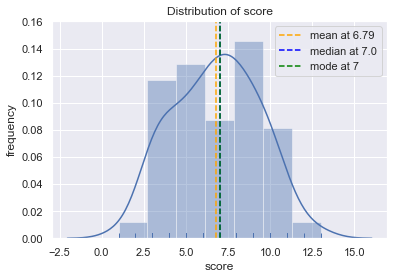

In [15]:
#EDA - Distribution of ‘score’
print("Skewness in the data for column 'score'",df_org.score.skew())
sns.distplot(df_org['score'],hist=True, kde=True, rug=True);
plt.xlabel("score")
plt.ylabel("frequency")
plt.title(f"Distribution of score")
measurements = [round(df_org.score.mean(),2), round(df_org.score.median(),2), round(df_org.score.mode()[0],2)]
names = ["mean", "median", "mode"]
colors = ['orange', 'blue', 'green']
for measurement, name, color in zip(measurements, names, colors):
    plt.axvline(x=measurement, linestyle='--', color=color, label='{0} at {1}'.format(name, measurement))
plt.legend();

Observations:
1. 'Skewness' of column 'score' is '-0.005' which is very close to zero and falling in the range of -1 and 1.
2. Both the sides are approximately symmetric from median and mean points. Hence, data seems to be normally distributed.

In [16]:
#EDA - Checking the presence of outliers in 'score'

#To get IQR for given column
def iqr(col_name):
    oneandhalf_iqr = (df_summary_fin.loc[col_name]['IQR'])*1.5
    outlier_lb = (df_summary_fin.loc[col_name]['25%'])-oneandhalf_iqr
    outlier_ub = (df_summary_fin.loc[col_name]['75%'])+oneandhalf_iqr
    return oneandhalf_iqr,outlier_lb,outlier_ub

#to get upper & lower outliers count, and its total count for given column
def outliers_cnt(col_name):
    lower_outliers = len(df_org[df_org[col_name]<iqr(col_name)[1]])
    upper_outliers = len(df_org[df_org[col_name]>iqr(col_name)[2]])
    total_outliers = len(df_org[df_org[col_name]<iqr(col_name)[1]])+len(df_org[df_org[col_name]>iqr(col_name)[2]])
    return lower_outliers, upper_outliers, total_outliers

In [17]:
outliers_dict = {"lower_outliers":outliers_cnt('score')[0], "upper_outliers":outliers_cnt('score')[1],"total_outliers":outliers_cnt('score')[2]}
print("Outlier details for 'score' : ", outliers_dict)

Outlier details for 'score' :  {'lower_outliers': 0, 'upper_outliers': 0, 'total_outliers': 0}


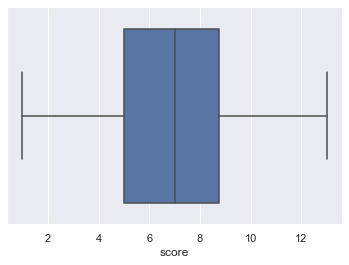

In [18]:
# Outlier details for 'score' of 'Arielle'
sns.boxplot(df_org[df_org['name'].isin(['Arielle'])].score);

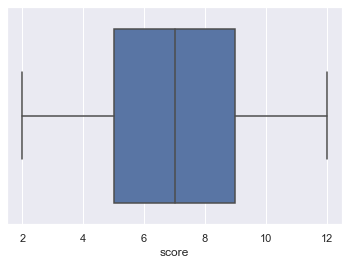

In [19]:
# Outlier details for 'score' of 'Boris'
sns.boxplot(df_org[df_org['name'].isin(['Boris'])].score);

Observations:
1. From the above boxplotting, I can observe that there are no outliers in the column 'score' for both 'Arielle' and 'Boris'

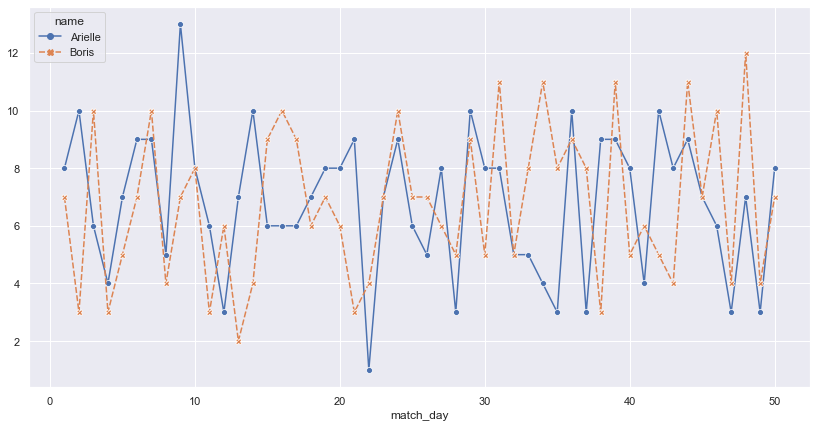

In [20]:
# match day wise individual performance trend
sns.set(rc={'figure.figsize':(14,7)})

df_temp = df_org.pivot("match_day", "name", "score")
sns.lineplot(data=df_temp, markers=True, dashes=True);

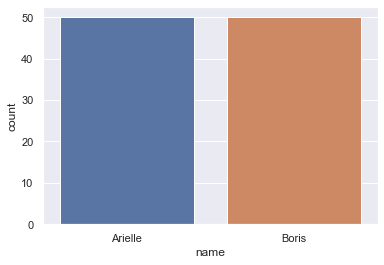

In [21]:
#Check record count of 'Arielle' and 'Boris'
sns.set(rc={'figure.figsize':(6,4)})

sns.countplot(df_org.name);

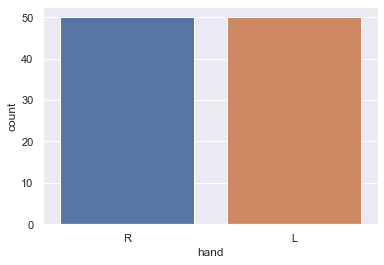

In [22]:
#Check record count of 'Right Hand' and 'Left Hand'
sns.countplot(df_org.hand);

Observations:
1. From the above count plot, it seems there are about 50 records in both the groups 'Arielle' and 'Boris'. Hence, the data is equally distributed across two classes ('Arielle' and 'Boris).
2. Also, groups 'Arielle' and 'Boris' are independent as events are NOT influenced by others.

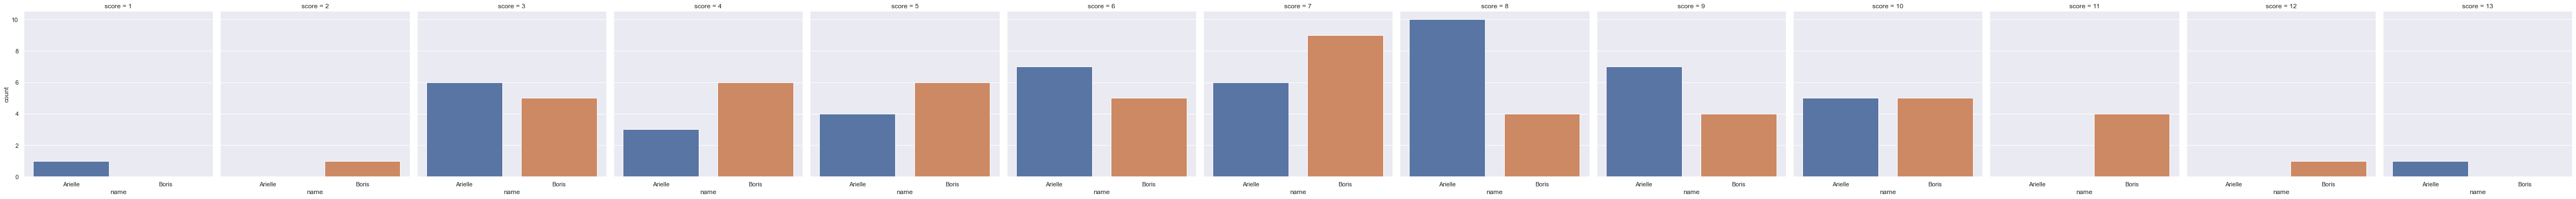

In [23]:
# Scores based on 'name' column
sns.catplot(x='name',col='score',data=df_org, kind='count',height=5);

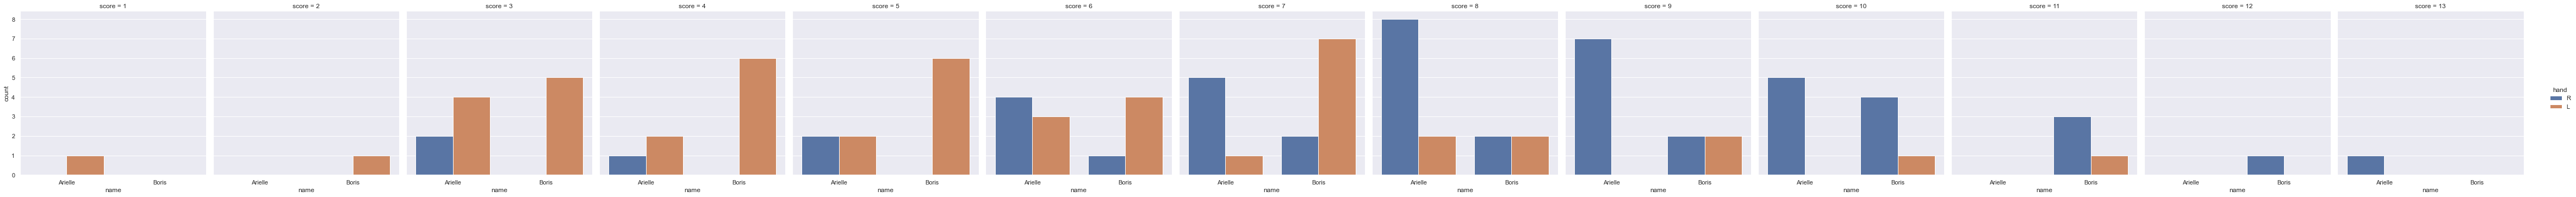

In [24]:
# Scores based on 'name' and 'hand' columns
sns.catplot(x='name',hue='hand',col='score',data=df_org, kind='count',height=5);

Average score of Arielle:  6.82
Average score of Boris:  6.76


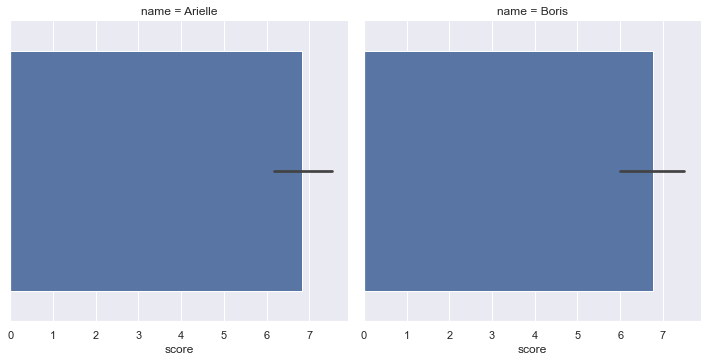

In [25]:
# Individual mean scores based on 'name'
sns.catplot(x='score', col='name',data=df_org, kind='bar',height=5);
print("Average score of Arielle: ", df_org[df_org['name'].isin(['Arielle'])]['score'].mean())
print("Average score of Boris: ", df_org[df_org['name'].isin(['Boris'])]['score'].mean())

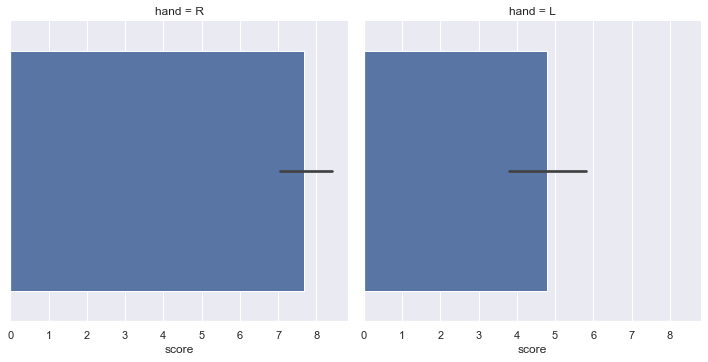

In [26]:
# Individual mean scores based on 'hand' for 'Arielle'
sns.catplot(x='score', col='hand',data=df_org[df_org['name'].isin(['Arielle'])], kind='bar',height=5);

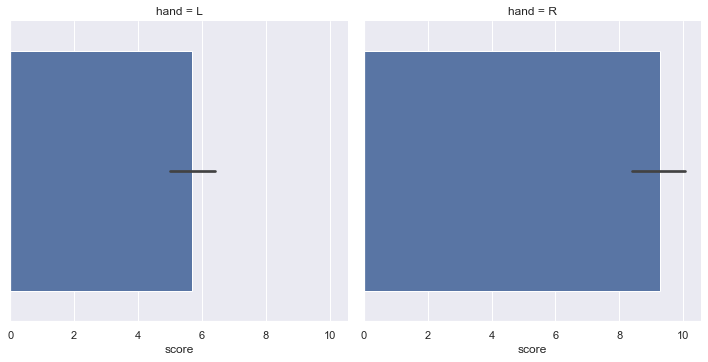

In [27]:
# Individual mean scores based on 'hand' for 'Boris'
sns.catplot(x='score', col='hand',data=df_org[df_org['name'].isin(['Boris'])], kind='bar',height=5);

Observation:
1. From above count plots, I see Arielle has scored '8' points 10 times(8 times with right hand and 2 times with left hand) which is two and half fold higher than that of 'Boris' score(2 times with right hand and 2 times with left hand)
2. Considering individual performance, 'Arielle' has scored the maximum point of '13' only once with his right hand.
3. Considering individual performance, 'Boris' has scored the maximum point of '12' only once with his right hand.
4. The average score of Arielle is very slightly better than 'Boris'.
5. Both 'Arielle' and 'Boris' were performing well with 'Right' hand over 'Left' hand

           match_day     score  attempts
match_day   1.000000  0.025914       NaN
score       0.025914  1.000000       NaN
attempts         NaN       NaN       NaN


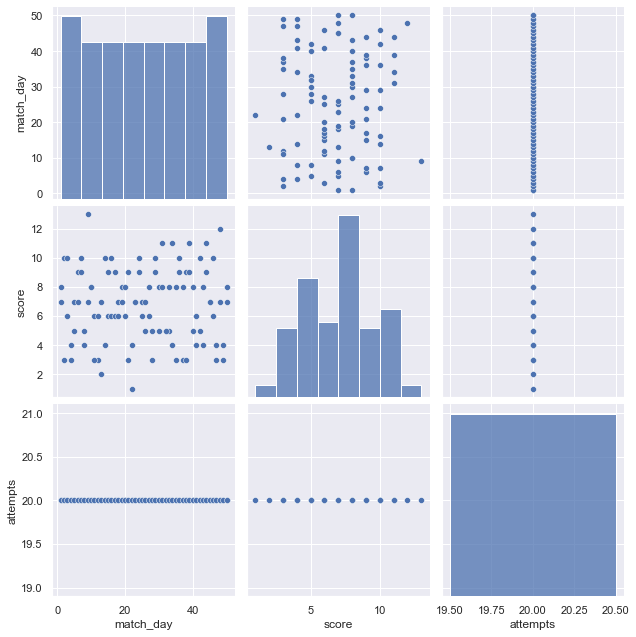

In [28]:
#EDA - Pair plot that includes all the columns of the data frame - Multivariate analysis
print(df_org.corr())
sns.pairplot(df_org, height=3);

Observation:
1. There is no linear relationship between the features 'match_day' and 'score'
2. Column 'attempts' doesn't contribute any significant value at all. Hence, 'attempts' column can be eliminated from overall analysis.
3. For further analysis, I'm going to consider only the columns 'name' and 'score' for parametric tests.

## Performing Hypothesis Test

In [30]:
# Is Arielle or Boris the better pancake flipper? Justify your decision. Do both sides have a case here?

# Setting Null and Alternate hypothesis states

# Ho: Arielle's pancake flipping performance is greater than or equal to Boris (status quo is '>=') - Null Hypothesis
# Ha: Arielle's pancake flipping performance is lesser than Boris - Alternate Hypothesis (<) - Alternate Hypothesis

df_arielle = df_org[df_org['name']=='Arielle'].score
df_boris = df_org[df_org['name']=='Boris'].score

# print(df_arielle.std()**2)
# print(df_boris.std()**2)

var_flag = False # variance is not equal
if df_arielle.std()**2 == df_boris.std()**2:
    var_flag = True # variance is equal
    
print(f"This is probability distribution analysis of mean - discrete variable 'score' for independent groups(Arielle & Boris) - two sample t-test considering two groups don't have same variance")
    
#default level of significance = 5%. Therefore, alpha = 0.05
#level of confidence = 95%

alpha = 0.05
confidence_level = (1-alpha)*100
t_stats, p_val = ttest_ind(df_arielle, df_boris, equal_var=var_flag) 
print("t-test value: '{0}' and p-value: '{1}'".format(t_stats, p_val))

if p_val>alpha:
    print(f"Arielle's pancake flipping performance is greater than or equal to Boris at {confidence_level}% confidence level. H0 is true")
else:
    print(f"Arielle's pancake flipping performance is lesser than Boris at {confidence_level}% confidence level. Ha is true")

This is probability distribution analysis of mean - discrete variable 'score' for independent groups(Arielle & Boris) - two sample t-test considering two groups don't have same variance
t-test value: '0.1175313817037812' and p-value: '0.9066804548784901'
Arielle's pancake flipping performance is greater than or equal to Boris at 95.0% confidence level. H0 is true


## Conclusion:

From the above performed exploratory data analysis and inferential statistical analysis, I have concluded as capture below.

1. Actual p-value is 0.91 which is greater than alpha value 0.05 at confidence interval of 95%. Hence, we CANNOT reject the Ho(Null Hypothesis).
2. As mean success rate of Arielle is slightly better than or equal to Boris, I can observe that Arielle is performing better. 
However, Boris perform is very close to Arielle but NOT better. Hence, I decide Arielle's pancake flipping skill is better over Boris's.
